In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score,precision_recall_fscore_support
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_split.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)


train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Using custom data configuration default-9ed78e0185729396
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 229.60it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-d8a73572c5526b09.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-71c34de47dd068c7.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9e4fe1ebeeeb9fd4.arrow


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 

In [4]:
columns_to_keep = ["claim", "premise", "label","category"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-f56a0271a09887b4.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-80cde756ccac5cc2.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-9ed78e0185729396/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-4a220ab4c7e19e55.arrow


Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [6]:
labels = np.array(dataset['train']['label'])

In [7]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='sjrhuschlee/flan-t5-base-mnli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        premise = item['premise'].replace('\n', '').replace('[','').replace(']','')
        item['claim']=claim
        item['premise']=premise
        
        # Tokenize the texts
        inputs = self.tokenizer(
            claim, premise,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        if 'label' in item:
            item['labels'] = torch.tensor(item['label'], dtype=torch.long)
        
        return item



In [8]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [9]:
model_name = "sjrhuschlee/flan-t5-base-mnli"
config = AutoConfig.from_pretrained(
    model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,ignore_mismatched_sizes=True,config=config, trust_remote_code=True)
device = "cuda:0"
model.to(device)

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedGeluDense(
                (wi_0): Linear(in_features=768, out_features=2048, bias=False)
                (wi_1): Line

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(
        logits, tuple
    ):  # if the model also returns hidden_states or attentions
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)


    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [11]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category'],
    num_rows: 1623
})

In [12]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()


In [13]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [14]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [15]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [16]:
tdata.__getitem__(0)

{'claim': 'Myrrh essential oil is sometimes used in skincare products to help improve the appearance of the skin.',
 'premise': '; Unković, N.; Dimkić, I.; Janaćković, P.; Gavrilović, M.; Stanojević, O.; Vukojević, J. Frankincense and myrrh essential oils and burn incense fume against micro-inhabitants of sacral ambients.Shameem, I. Phytochemical & therapeutic potentials of Murr makki (.Oxidative stress and immunotoxic effects of lead and their amelioration with myrrh (Commiphora molmol) emulsion.Essential Oils: Magical Ingredients for Skin Care.Chakravarty, N.; Kellogg, C.; Alvarez, J.; Equils, O.; Morgan, M. UV Protection by Natural Products: C. myrrha Oil Versus Sunscreen.Hamidpour, R.; Hamidpour, S.; Hamidpour, M.; Shahlari, M. Frankincense (乳香 Rǔ Xiāng;.species): From the selection of traditional applications to the novel phytotherapy for the prevention and treatment of serious diseases.Chemistry and immunomodulatory activity of frankincense oil.Compositions containing Boswellia e

In [17]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/10.2.1_flant5/',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=False,
    warmup_ratio=0.06,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/10.2.1_flant5/best_model')
tokenizer.save_pretrained(f'/home/elson/10.2.1_flant5/best_model')


/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3045


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.886300,0.799861,0.679570,0.544130,0.679570,0.572926
2,0.742800,0.764673,0.666667,0.611819,0.666667,0.630654
3,0.609300,0.870856,0.653763,0.636418,0.653763,0.644748
4,0.753100,1.096024,0.651613,0.644415,0.651613,0.647512
5,0.564200,1.401636,0.651613,0.651252,0.651613,0.650711
6,0.683000,1.655139,0.643011,0.649681,0.643011,0.645948
7,0.265200,2.200283,0.638710,0.644550,0.638710,0.640666
8,0.142200,2.339462,0.630108,0.651066,0.630108,0.639789
9,0.286600,2.458558,0.640860,0.642905,0.640860,0.640741
10,0.120100,2.632831,0.643011,0.649995,0.643011,0.646080


***** Running Evaluation *****
  Num examples = 465
  Batch size = 8
Saving model checkpoint to /home/elson/10.2.1_flant5/checkpoint-203
Configuration saved in /home/elson/10.2.1_flant5/checkpoint-203/config.json
Model weights saved in /home/elson/10.2.1_flant5/checkpoint-203/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 8
Saving model checkpoint to /home/elson/10.2.1_flant5/checkpoint-406
Configuration saved in /home/elson/10.2.1_flant5/checkpoint-406/config.json
Model weights saved in /home/elson/10.2.1_flant5/checkpoint-406/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 8
Saving model checkpoint to /home/elson/10.2.1_flant5/checkpoint-609
Configuration saved in /home/elson/10.2.1_flant5/checkpoint-609/config.json
Model weights saved in /home/elson/10.2.1_flant5/checkpoint-609/pytorch_model.bin
Deleting older checkpoint [/home/elson/10.2.1_flant5/checkpoint-406] due to args.save_total_limit
***** Running Eva

Configuration saved in /home/elson/10.2.1_flant5/best_model/config.json
Model weights saved in /home/elson/10.2.1_flant5/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/10.2.1_flant5/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/10.2.1_flant5/best_model/special_tokens_map.json
Copy vocab file to /home/elson/10.2.1_flant5/best_model/spiece.model


('/home/elson/10.2.1_flant5/best_model/tokenizer_config.json',
 '/home/elson/10.2.1_flant5/best_model/special_tokens_map.json',
 '/home/elson/10.2.1_flant5/best_model/spiece.model',
 '/home/elson/10.2.1_flant5/best_model/added_tokens.json',
 '/home/elson/10.2.1_flant5/best_model/tokenizer.json')

In [19]:
model_path = "/home/elson/10.2.1_flant5/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path,trust_remote_code=True).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/10.2.1_flant5/best_model/config.json
Model config T5Config {
  "_name_or_path": "/home/elson/10.2.1_flant5/best_model/",
  "architectures": [
    "T5ForSequenceClassification"
  ],
  "auto_map": {
    "AutoModelForSequenceClassification": "modeling_t5seq.T5ForSequenceClassification"
  },
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "finetuning_task": "mnli",
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "label2id": {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
  },
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "p

In [20]:
print(test_results)

PredictionOutput(predictions=(array([[-0.18117598,  1.2022704 , -1.2650553 ],
       [ 0.3142954 ,  1.6176083 , -1.980114  ],
       [-0.46837243,  1.4232664 , -1.2079489 ],
       [ 0.36779153,  1.5423898 , -2.0520165 ],
       [ 0.6199041 ,  1.0615779 , -1.7161404 ],
       [ 0.05210482,  2.1601913 , -2.326343  ],
       [-0.18066828,  1.1886368 , -1.1513442 ],
       [-0.53056544,  1.3160526 , -1.0660194 ],
       [-0.45456278,  1.8161242 , -1.6636243 ],
       [ 0.07286944,  1.1330833 , -1.3509222 ],
       [-0.07864268,  1.167221  , -1.3292598 ],
       [-0.14985503,  1.3873892 , -1.4818606 ],
       [ 0.55160713,  1.2389324 , -1.7443116 ],
       [ 0.59537894,  0.5789019 , -1.098087  ],
       [-0.15284307,  0.7885192 , -0.81585026],
       [-0.29941085,  1.1267908 , -1.0722989 ],
       [-0.4688474 ,  1.7526101 , -1.50858   ],
       [ 0.5605945 ,  1.2423924 , -1.7867109 ],
       [-0.10827423,  1.4885786 , -1.45004   ],
       [ 0.53863597,  1.8451033 , -2.3629932 ],
       [ 0

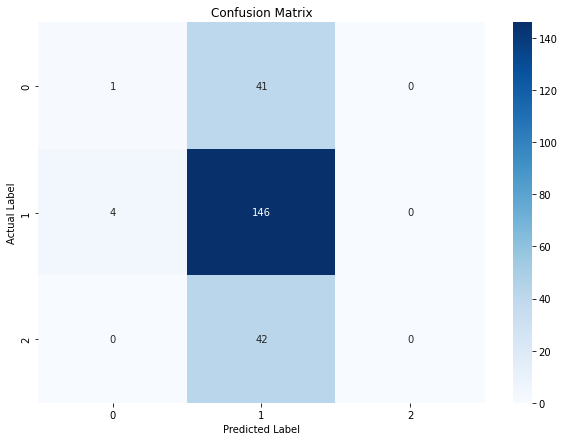

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
predictions_array = np.array(test_results.predictions[0])

predictions_tensor = torch.tensor(predictions_array).to(torch.float32)
probabilities = torch.softmax(predictions_tensor, dim=-1)

predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [23]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/10.2.1_results.csv', index=False)

In [24]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [25]:
correct_classification_counts

General Health           32
Fitness                  15
Bone health              12
Cancer                   11
Throat                    9
Hair                      9
Diabetes                  9
Skin                      8
Neurological health       8
Ear                       6
COVID                     6
Eye                       6
Cardiovascular Health     6
Mental Health             3
Muscles                   3
Blood                     3
Men's health              1
Name: Category, dtype: int64

In [26]:
misclassification_counts

General Health           19
Skin                     16
Bone health               9
Blood                     6
Women' s Health           6
Cardiovascular Health     6
Men's health              5
Vascular                  3
Muscles                   3
Eye                       3
Dental Health             3
Hair                      3
Diabetes                  3
Cancer                    1
Neurological health       1
Name: Category, dtype: int64